# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.patches import Patch
from   matplotlib.ticker import FuncFormatter
from   matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.linear_model import QuantileRegressor

This notebook will exame the comparison of Treasury returns and SPX return on a pre FOMC basis.

## Data Prep

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

In [3]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            PX_diff = lambda x: x.PX_LAST.diff(),
            bps     = lambda x: x.PX_diff / x.duration))

def get_tsy_bps() -> pd.DataFrame: 

    data_prep = DataPrep()

    df_tsy = data_prep.get_fut_data()
    df_deliv = data_prep.get_bond_deliverables()

    df_duration = (df_deliv.query(
        "variable == 'CONVENTIONAL_CTD_FORWARD_FRSK'").
        drop(columns = ["variable"]).
        rename(columns = {"value": "duration"}))


    df_out = (df_tsy.merge(
        right = df_duration, how = "inner", on = ["date", "security"]).
        groupby("security").
        apply(_get_bps).
        reset_index(drop = True))
    
    return df_out

def prep_nlp() -> pd.DataFrame: 
    
    df_nlp = (DataPrep().get_labor_sentiment().reset_index().assign(
        date = lambda x: pd.to_datetime(x.date).dt.date))
    
    return df_nlp

df_tsy_bps = get_tsy_bps()
df_nlp = prep_nlp()

Searching for Futures Data
Found Data

Searching for Bond Future Deliverables
Found Data

Searching for Labor Data
Found Data



In [4]:
def _lag_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(lag_bps = lambda x: x.bps.shift()))

def _get_order(df: pd.DataFrame, before: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        reset_index(drop = True).
        reset_index().
        rename(columns = {"index": "day"}).
        assign(day = lambda x: x.day + before))
    
    return df_out

In [5]:
def get_order_bps(df_tsy_bps: pd.DataFrame, before: float = -6, after: float = 2) -> pd.DataFrame: 

    df_lag = (df_tsy_bps.groupby(
        "security").
        apply(_lag_bps).
        reset_index(drop = True))

    min_date = df_lag.date.min().date()
    df_dates = (BBGCollect()._get_days_window(
        ticker = "FDTR", before = before, after = after).
        query("start_date >= @min_date").
        reset_index(drop = True))

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row

        df_tmp = (df_lag.query(
            "@start_date <= date <= @end_date").
            groupby("security").
            apply(_get_order, before).
            assign(event = i + 1).
            reset_index(drop = True))

        df_combined = pd.concat([df_combined, df_tmp])

    df_year = (df_combined.assign(
        year = lambda x: pd.to_datetime(x.date).dt.year))

    bad_years = (df_year[
        ["year", "event"]].
        drop_duplicates().
        groupby("year").
        agg("count").
        query("event > 8").
        index.
        to_list())

    keep_events = (df_year.query(
        "year == @bad_years")
        [["event", "year"]].
        drop_duplicates().
        groupby("year").
        head(8).
        event.
        drop_duplicates().
        to_list())

    df_out = (pd.concat([
        df_year.query("year == @bad_years & event == @keep_events"),
        df_year.query("year != @bad_years")]).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date))
    
    return df_out

df_order_bps = get_order_bps(df_tsy_bps)

In [6]:
def get_equity(df_order_bps: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (DataPrep().get_equity_data().assign(
        date = lambda x: pd.to_datetime(x.date).dt.date,
        security = lambda x: x.security.str.split(" ").str[0]).
        pivot(index = "date", columns = "security", values = "value").
        dropna().
        sort_index().
        assign(
            spx_rtn = lambda x: x.ES1.pct_change(),
            fut_spx = lambda x: x.spx_rtn.shift(),
            lag_vix = lambda x: x.VIX.shift()))

    dates = df_order_bps.date.drop_duplicates().to_list()
    df_out = (pd.concat([
        df_tmp.query("date == @dates").assign(event_date = True),
        df_tmp.query("date != @dates").assign(event_date = False)]))
    
    return df_out

df_equity = get_equity(df_order_bps)

Searching for equity data
Found equity data


In [7]:
def prep_data(df_order_bps: pd.DataFrame, df_nlp: pd.DataFrame, df_equity: pd.DataFrame) -> pd.DataFrame: 
    
    df_event = (df_order_bps[
        ["day", "date", "event"]].
        drop_duplicates().
        merge(right = df_nlp, how = "inner", on = ["date"]).
        query("day == -6")
        [["event", "BENLPFED"]].
        assign(sentiment = lambda x: np.where(x.BENLPFED < 0, "neg", "pos")))

    df_tmp = (df_equity[
        ["spx_rtn"]].
        merge(right = df_order_bps, how = "inner", on = ["date"]).
        query("-6 < day < 0")
        [["date", "spx_rtn", "bps", "lag_bps", "event", "security"]].
        merge(right = df_event, how = "inner", on = ["event"]).
        assign(security = lambda x: x.security.str.split(" ").str[0]))
    
    return df_tmp

df_prep = prep_data(df_order_bps, df_nlp, df_equity)

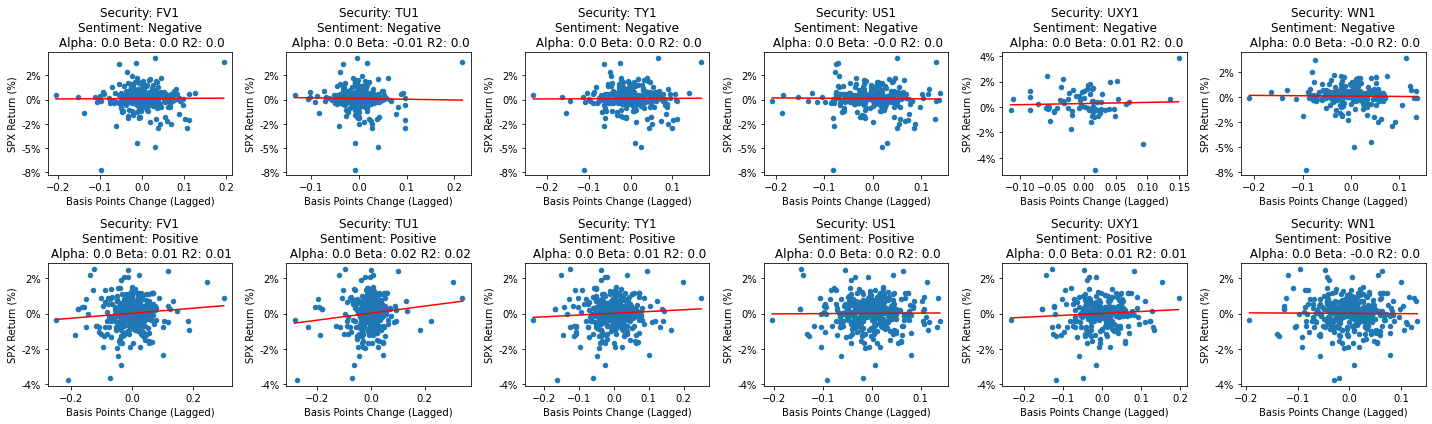

In [8]:
def _regress(df: pd.DataFrame, group_var: str, ax):
        
    sentiment_dict = {"neg": "Negative", "pos": "Positive"}
    sentiment, security = group_var.split("_")
    
    ols = (sm.OLS(
        endog = df.spx_rtn,
        exog = sm.add_constant(df.lag_bps)).
        fit())
    
    alpha, beta = ols.params
    rsquared = ols.rsquared

    (df.plot(
        ax    = ax,
        kind  = "scatter",
        x     = "lag_bps",
        y     = "spx_rtn",
        title = "Security: {}\nSentiment: {}\n Alpha: {} Beta: {} R2: {}".format(
            security, sentiment_dict[sentiment],
            round(alpha, 2),
            round(beta, 2),
            round(rsquared, 2))))
    
    x = np.linspace(start = df.lag_bps.min(), stop = df.lag_bps.max(), num = 1_000)
    y = (beta * x) + alpha
    ax.plot(x, y, "red")
    

df_tmp = (df_prep.assign(
    group_var = lambda x: x.sentiment + "_" + x.security))

group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(ncols = len(group_vars) // 2, nrows = 2, figsize = (20,6))

for group_var, ax in zip(group_vars, axes.flatten()):
    
    df_plot = df_tmp.query("group_var == @group_var")
    _regress(df_plot, group_var, ax)
    ax.set_xlabel("Basis Points Change (Lagged)")
    ax.set_ylabel("SPX Return (%)")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plt.tight_layout()

## Pure Equity Returns

Play back the equity returns during the fed funds announcements. Rather than grouping the returns by the Federal Funds announcement instead use the sentiment of the Bloomberg NLP sentiment, the playback of returns will also close out before the Fed announcement occurs

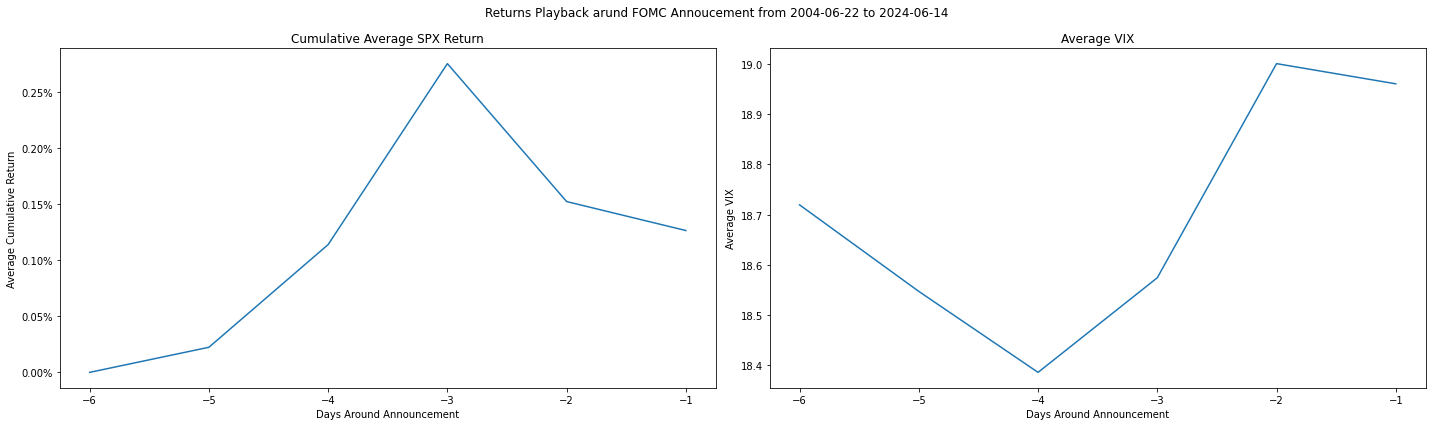

In [9]:
def plot_equity_playback_return(df_order_bps: pd.DataFrame, df_equity: pd.DataFrame) -> plt.Figure: 
    
    df_combined = (df_order_bps[
        ["day", "event", "date"]].
        merge(right = df_equity, how = "inner", on = ["date"])
        [["day", "event", "fut_spx", "VIX"]].
        query("day <= -1").
        drop_duplicates())

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_combined.drop(
        columns = ["VIX"]).
        assign(fut_spx = lambda x: np.where(x.day == x.day.min(), 0, x.fut_spx)).
        pivot(index = "day", columns = "event", values = "fut_spx").
        mean(axis = 1).
        to_frame(name = "SPX").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            ylabel = "Average Cumulative Return",
            legend = False,
            title  = "Cumulative Average SPX Return",
            xlabel = "Days Around Announcement"))

    (df_combined.drop(
        columns = ["fut_spx"]).
        pivot(index = "day", columns = "event", values = "VIX").
        mean(axis = 1).
        to_frame(name = "VIX").
        plot(
            ax     = axes[1],
            legend = False,
            ylabel = "Average VIX",
            title  = "Average VIX",
            xlabel = "Days Around Announcement"))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))
    fig.suptitle("Returns Playback arund FOMC Annoucement from {} to {}".format(
        df_order_bps.date.min(),
        df_order_bps.date.max()))
    plt.tight_layout()
    

plot_equity_playback_return(df_order_bps, df_equity)

Now try playing back these returns (which is overfitted in-sample). In this case buy equities 6 days before and sell them back 3 days before. As per VIX futures buy them 4 days before and sell them back 2 days before FOMC events

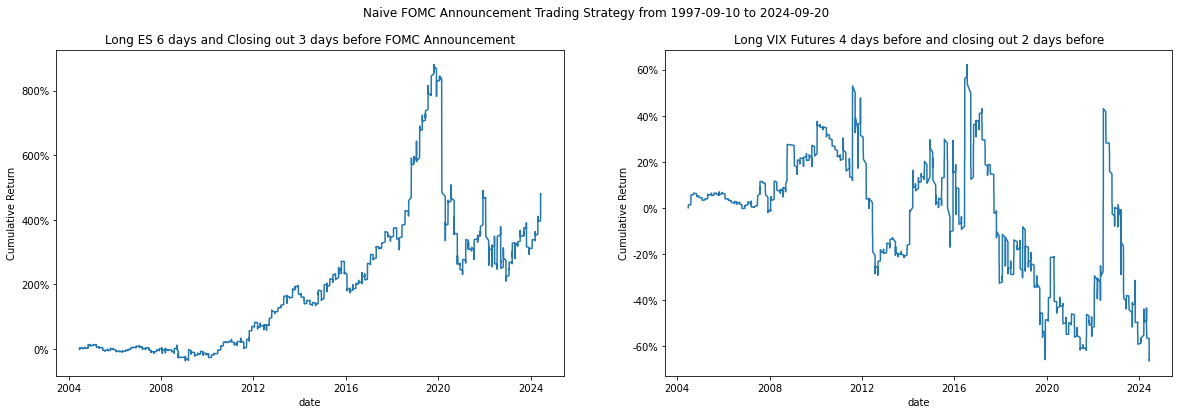

In [10]:
def plot_equity_playback(df_order_bps: pd.DataFrame, df_equity: pd.DataFrame) -> pd.DataFrame: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_equity.reset_index().assign(
        date = lambda x: pd.to_datetime(x.date).dt.date)
        [["date", "fut_spx"]].
        merge(right = df_order_bps, how = "inner", on = ["date"]).
        query("day <= -3")
        [["date", "fut_spx"]].
        sort_values("date").
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            legend = False,
            title = "Long ES 6 days and Closing out 3 days before FOMC Announcement"))

    (DataPrep().get_vix_futures()[
        ["date", "PX_RTN"]].
        merge(right = df_order_bps, how = "inner", on = ["date"]).
        query("-4 <= day <= -2")
        [["date", "PX_RTN"]].
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[1],
            legend = False,
            title = "Long VIX Futures 4 days before and closing out 2 days before"))

    for ax in axes.flatten():

        ax.set_ylabel("Cumulative Return")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
        
    fig.suptitle("Naive FOMC Announcement Trading Strategy from {} to {}".format(
        df_equity.index.min(),
        df_equity.index.max()))
    
plot_equity_playback(df_order_bps, df_equity)